<a href="https://colab.research.google.com/github/rpasquini/urban-econometrics/blob/master/Correlacion_espacial_y_Regresi%C3%B3n_espacial_intro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

_author: Ricardo Pasquini (rpasquini@gmail.com)

In [34]:
!pip install geopandas

In [35]:
!pip install libpysal 

In [36]:
!pip install splot


In [37]:
!pip install esda
import esda

In [57]:
!pip install spreg

In [38]:
import geopandas as gpd

In [39]:
from libpysal.weights import Queen, Rook, KNN, Kernel, DistanceBand

In [40]:
from splot.libpysal import plot_spatial_weights

In [41]:
import matplotlib.pyplot as plt


In [42]:
from splot.esda import plot_moran

In [83]:
import pandas as pd

In [133]:
#import libpysal

# Preparamos los datos
Por una limitación de la versión de Colab con la que trabajamos aquí (cantidad de RAM), no podremos correr las medidas espaciales en toda la base de datos, asi que vamos a trabajar con una muestra de datos para CABA. 

In [43]:
departamentos=gpd.GeoDataFrame.from_file("https://github.com/rpasquini/urban-econometrics/blob/master/data/departamentos2019amba.zip?raw=true")

In [44]:
departamentosCABA=departamentos.loc[departamentos.l2=='Capital Federal']

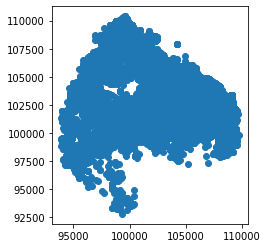

In [45]:
departamentosCABA.plot()

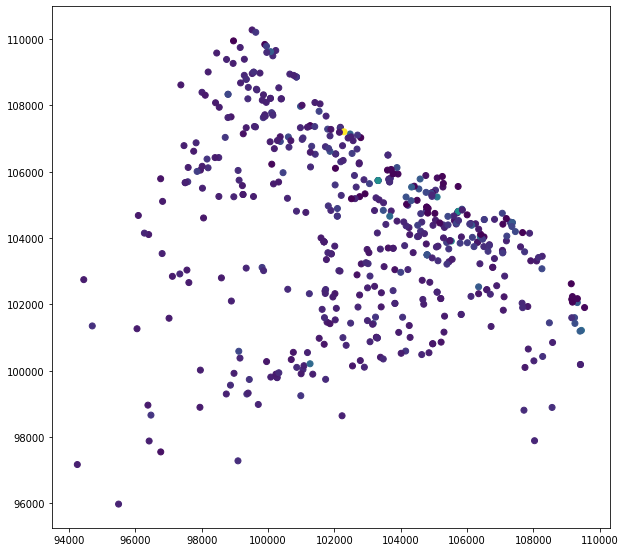

In [161]:
#primeros 500 datos
departamentosCABA2=departamentosCABA.iloc[0:500]
#elimino outliers para este ejemplo
departamentosCABA2=departamentosCABA2.loc[departamentosCABA2.price<80000]
departamentosCABA2=departamentosCABA2[['price','bedrooms','geometry']].dropna()

fig, ax = plt.subplots(figsize=(10, 10))
departamentosCABA.iloc[0:500].plot(column='price', ax=ax)

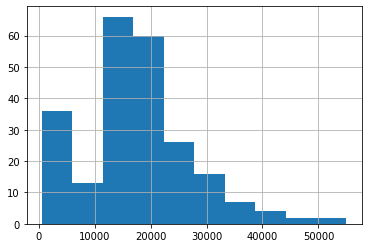

In [47]:
departamentosCABA2.price.hist()

# Matriz de pesos espaciales

La matriz de pesos es el objeto en donde representamos las relaciones entre las observaciones. El contenido de la matriz depende de la forma que establezcamos para medir la dependencia espacial. 

Cuando trabajamos con poligonos (por ejemplo partidos o  radios censales) es natural definir relaciones basadas en la contiguidad. 

En este caso, en cambio, como  trabajamos con puntos, lo razonable es que la medida se base en distancias relativas.

Pysal tiene varias funcionalidades para implementar pesos. Los pesos por distancia  (DistanceBand) van a considerar la cantidad de vecinos para una distancia determinada.

Tener en cuenta también que el threshold esta definido de acuerdo a la proyección en la que estén los datos.


En primer lugar construiremos una matriz en base a un theshold de distancia usando DistanceBand. https://pysal.org/libpysal/generated/libpysal.weights.DistanceBand.html#libpysal.weights.DistanceBand

In [157]:
# Con el medodo from_dataframe puedo generar directamente los weights usando un threshold (distancia maxima) determinada
wdistance=DistanceBand.from_dataframe(departamentosCABA2, threshold=1000)

/usr/local/lib/python3.7/dist-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 20 disconnected components.
 There are 14 islands with ids: 79, 193, 226, 247, 263, 357, 439, 468, 469, 540, 558, 567, 594, 727.
  warnings.warn(message)


In [158]:
wdistance

In [104]:
# cardinalities define el número de vecinos
len(wdistance.cardinalities)

232

In [105]:
wdistance.cardinalities

{0: 76,
 2: 53,
 4: 44,
 54: 74,
 56: 53,
 57: 62,
 58: 76,
 64: 102,
 67: 114,
 68: 115,
 69: 113,
 70: 112,
 71: 92,
 75: 61,
 77: 62,
 78: 57,
 79: 12,
 81: 84,
 85: 75,
 112: 98,
 117: 59,
 119: 98,
 120: 62,
 121: 62,
 124: 18,
 126: 32,
 134: 13,
 137: 40,
 138: 14,
 164: 48,
 165: 55,
 176: 96,
 177: 114,
 180: 115,
 184: 104,
 186: 80,
 189: 90,
 190: 93,
 191: 62,
 192: 26,
 193: 6,
 194: 68,
 195: 67,
 196: 60,
 197: 68,
 198: 56,
 203: 77,
 206: 24,
 207: 25,
 208: 98,
 209: 102,
 210: 90,
 215: 84,
 226: 68,
 228: 27,
 238: 104,
 239: 109,
 245: 74,
 247: 2,
 248: 63,
 249: 33,
 250: 38,
 252: 23,
 253: 46,
 255: 36,
 256: 33,
 263: 8,
 264: 14,
 296: 95,
 300: 14,
 306: 25,
 309: 18,
 310: 45,
 311: 29,
 314: 55,
 316: 65,
 317: 87,
 318: 99,
 319: 68,
 325: 109,
 326: 101,
 327: 91,
 328: 115,
 329: 99,
 330: 84,
 331: 92,
 333: 114,
 334: 98,
 335: 92,
 336: 94,
 337: 98,
 338: 97,
 339: 103,
 340: 98,
 341: 84,
 342: 89,
 343: 87,
 344: 88,
 346: 109,
 348: 95,
 349: 97

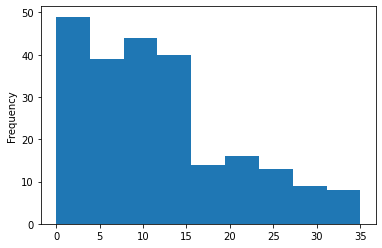

In [160]:
#distanceband.histogram
pd.Series(wdistance.cardinalities).plot.hist(bins=9)

Representacion espacial uniendo al número de vecinos

(<Figure size 720x720 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f8933440e10>)

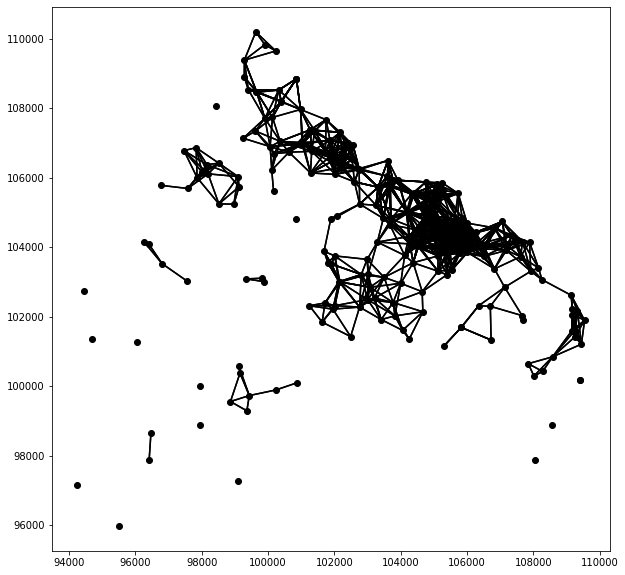

In [159]:
# el método plot permite una representacion grafica
fig, ax = plt.subplots(figsize=(10, 10))
wdistance.plot(departamentosCABA2, ax=ax)

In [70]:
kernelWa = Kernel.from_dataframe(departamentosCABA2, k=10, fixed=False, function='gaussian', diagonal=True)
kernelWa

# Moran

Concepto de rezago espacial
$y^{lag}_{i}=\sum w_iy_i$

El scatterplot de Moran muestra a la variable $y_i$ (eje x) contra su rezago espacial $y^{lag}_i$ (eje y). 
El estadistico de Moran es equivalente al coeficiente de la pendiente lineal de esta relación.
Su intuición es simple: si hay una relación positiva entre la variable y sus rezagos espaciales es porque hay correlación espacial. 

(<Figure size 720x288 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f89357b0810>,
       dtype=object))

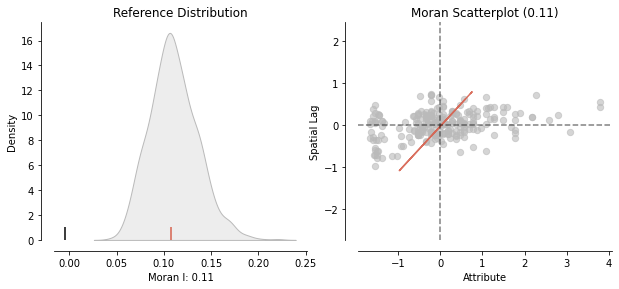

In [155]:
plot_moran(mi, zstandard=True, figsize=(10,4))
#plt.show()

El estadístico I de Moran es la pendiente de la regresión.


In [49]:
mi = esda.moran.Moran(departamentosCABA2.price, kernelWa)
mi.I

0.10754371168157624

# Spatial Regression


In [58]:
import spreg

In [128]:
wdistance.transform = 'r'

el [método OLS de spreg](http://www.pysal.org/spreg/generated/spreg.OLS.html#spreg.OLS) permite correr una regresión OLS pero además correr algunos tests de Moran sobre los residuos


In [152]:
name_y="price"
name_x=["bedrooms"]
results=spreg.OLS(departamentosCABA2.price.values[:, None], departamentosCABA2.bedrooms.values[:, None], w=wdistance, spat_diag=True, moran=True, name_y=name_y, name_x=name_x)

In [153]:
print(results.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :       price                Number of Observations:         232
Mean dependent var  :  17318.0172                Number of Variables   :           2
S.D. dependent var  :   9950.5996                Degrees of Freedom    :         230
R-squared           :      0.0012
Adjusted R-squared  :     -0.0032
Sum squared residual:22845554783.214                F-statistic           :      0.2696
Sigma-square        :99328499.057                Prob(F-statistic)     :      0.6041
S.E. of regression  :    9966.368                Log likelihood        :   -2464.207
Sigma-square ML     :98472218.893                Akaike info criterion :    4932.414
S.E of regression ML:   9923.3169                Schwarz criterion     :    4939.307

--------------------------------------------------------------------------

In [138]:
print( 'moran', results.moran_res[0])
print( 'standarized value', results.moran_res[1])
print( 'pvalue', results.moran_res[2])

moran -0.020602028117054784
standarized value 1.1428656053789916
pvalue 0.2530943948247649


In [145]:
import statsmodels.api as sm
Y=departamentosCABA2.price
X=departamentosCABA2.bedrooms
X=sm.add_constant(X)
modelo=sm.OLS(Y,X)
resultados=modelo.fit()
print (resultados.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.003
Method:                 Least Squares   F-statistic:                    0.2696
Date:                Wed, 09 Jun 2021   Prob (F-statistic):              0.604
Time:                        16:27:24   Log-Likelihood:                -2464.2
No. Observations:                 232   AIC:                             4932.
Df Residuals:                     230   BIC:                             4939.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.664e+04   1459.955     11.398      0.0

# Regresión básica con un lag espacial (2SLS)
$y=\rho Wy+\beta X+\epsilon$ \\
donde el primer termino representa al rezago espacial. \\
$\rho$ es el coeficiente del rezago \\
W es la matriz de pesos espaciales \\
X es la matriz de variables explicativas exógenas.

Documentation(https://pysal.org/spreg/notebooks/GM_Lag_example.html)

In [151]:
name_y="price"
name_x=["bedrooms"]
model = spreg.GM_Lag(departamentosCABA2.price.values[:, None], departamentosCABA2.bedrooms.values[:, None], w=wdistance, name_y=name_y, name_x=name_x)
print(model.summary)


REGRESSION
----------
SUMMARY OF OUTPUT: SPATIAL TWO STAGE LEAST SQUARES
--------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :       price                Number of Observations:         232
Mean dependent var  :  17318.0172                Number of Variables   :           3
S.D. dependent var  :   9950.5996                Degrees of Freedom    :         229
Pseudo R-squared    :      0.0389
Spatial Pseudo R-squared: omitted due to rho outside the boundary (-1, 1).
------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
------------------------------------------------------------------------------------
            CONSTANT    76374.0067304    117919.3243224       0.6476802       0.5171918
            bedrooms     121.9855789     954.3142391       0.1278254       0.8982872
             W_p